In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score
import joblib

In [19]:
# ==========================================
# 2. Exploratory Data Analysis (EDA)
# ==========================================

# Loading the dataset
df = pd.read_csv('monthly_data_interpolated.csv')

In [21]:
# Overview of data
print("Dataset Summary:\n", df.describe())

Dataset Summary:
               Year        Month          LST         NDVI         NDBI  \
count  3300.000000  3300.000000  3300.000000  3300.000000  3300.000000   
mean   2019.000000     6.500000    32.981590     0.323424    -0.129960   
std       3.162757     3.452576     2.866605     0.042322     0.035582   
min    2014.000000     1.000000    24.352433     0.162447    -0.192002   
25%    2016.000000     3.750000    31.259100     0.306029    -0.155373   
50%    2019.000000     6.500000    33.112299     0.329509    -0.132189   
75%    2022.000000     9.250000    34.851048     0.351748    -0.111895   
max    2024.000000    12.000000    42.560405     0.406529    -0.029853   

        Population  
count  2100.000000  
mean      4.191208  
std       5.948160  
min       0.173782  
25%       1.089791  
50%       2.138003  
75%       5.101301  
max      29.912287  


In [22]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 District         0
DS_Name          0
Year             0
Month            0
Date             0
LST              0
NDVI             0
NDBI             0
Population    1200
dtype: int64


In [23]:
# ==========================================
# 3. Data Preprocessing
# ==========================================

# 1. Dropping old District column (Justification: DS_Name will be used as District)
df = df.drop(columns=['District'])

# 2. Renaming DS_Name to District
df = df.rename(columns={'DS_Name': 'District'})

# 3. Removing duplicate records
df = df.drop_duplicates()

# 4. Handling missing values in Population using mean imputation
df['Population'] = df['Population'].fillna(df['Population'].mean())

# 5. Creating Target Class for classification using NDBI Median
median_ndbi = df['NDBI'].median()
df['Class'] = df['NDBI'].apply(lambda x: 1 if x > median_ndbi else 0)

# 6. Encoding categorical variables (District names)
le = LabelEncoder()
df['District_Encoded'] = le.fit_transform(df['District'].astype(str))

# 7. Train-Test Splitting
# For Classification (LST, NDVI, NDBI, Population -> Class)
X_cls = df[['LST', 'NDVI', 'NDBI', 'Population']]
y_cls = df['Class']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# For Regression (District_Encoded, Year -> Factors)
X_reg = df[['District_Encoded', 'Year']]
y_reg = df[['LST', 'NDVI', 'NDBI', 'Population']]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 8. Feature Scaling for Classification
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)

print("Preprocessing complete. Final Columns:", df.columns)

Preprocessing complete. Final Columns: Index(['District', 'Year', 'Month', 'Date', 'LST', 'NDVI', 'NDBI',
       'Population', 'Class', 'District_Encoded'],
      dtype='object')


In [24]:
# ==========================================
# 4. Model Development
# ==========================================

# Applying Random Forest (Traditional Machine Learning Algorithm)
# Classification Model (Updated version without NDBI to ensure realistic accuracy)
X_cls_new = df[['LST', 'NDVI', 'Population']] 
y_cls_new = df['Class']

X_train_cn, X_test_cn, y_train_cn, y_test_cn = train_test_split(X_cls_new, y_cls_new, test_size=0.2, random_state=42)

scaler_new = StandardScaler()
X_train_cn = scaler_new.fit_transform(X_train_cn)
X_test_cn = scaler_new.transform(X_test_cn)

cls_model_new = RandomForestClassifier(n_estimators=100, random_state=42)
cls_model_new.fit(X_train_cn, y_train_cn)

# Regression Model Training
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train_r, y_train_r)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# ==========================================
# 5. Model Evaluation and Prediction
# ==========================================

# 1. Regression Metrics (MAE, MSE, RMSE, R2)
from sklearn.metrics import mean_squared_error
y_pred_r = reg_model.predict(X_test_r)
mse = mean_squared_error(y_test_r, y_pred_r)

print("\n======= REGRESSION METRICS =======")
print(f"MAE:  {mean_absolute_error(y_test_r, y_pred_r):.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")


======= REGRESSION METRICS =======
MAE:  0.2057
MSE:  0.2532
RMSE: 0.5032
R2 Score: 0.9557



======= CLASSIFICATION METRICS =======
Accuracy: 0.9485

Detailed Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       337
           1       0.94      0.96      0.95       323

    accuracy                           0.95       660
   macro avg       0.95      0.95      0.95       660
weighted avg       0.95      0.95      0.95       660



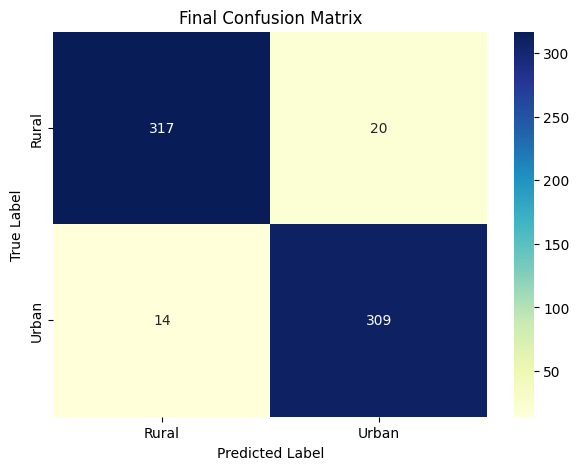

In [29]:
# 2. Classification Metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
y_pred_new = cls_model_new.predict(X_test_cn)

print("\n======= CLASSIFICATION METRICS =======")
print(f"Accuracy: {accuracy_score(y_test_cn, y_pred_new):.4f}")
print("\nDetailed Report:")
print(classification_report(y_test_cn, y_pred_new))

# Confusion Matrix Visualization
cm_new = confusion_matrix(y_test_cn, y_pred_new)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['Rural', 'Urban'], 
            yticklabels=['Rural', 'Urban'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()